In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, jdc, shutil
from tqdm import tqdm
import seaborn as sns
import datetime
import pickle
import scipy.stats as st
import tensorflow as tf
import pandas as pd
import random
from collections import deque
import random

path = '/Users/louisserrano/Documents/Oxford/Courses/Trinity/Dissertation/Code/Toy Experiments/'
os.chdir(path)

from Scripts.rl_glue_horde import RLGlueHorde
from Scripts.toy_env_horde import ToyEnvironment
from Scripts.separateHorde.separateHorde import SeparateHorde
from Scripts.utils import bernouilli_cumulant, gaussian_cumulant, wall_detector_cumulant, gvd_based_cumulant, ReplayBuffer
from Scripts.utils import plot_q_values, save_theta, plot_theta

path = '/Users/louisserrano/Documents/Oxford/Courses/Trinity/Dissertation/Code/Toy Experiments/Notebooks/GVD'
os.chdir(path)

In [3]:
v_policy3 = np.load("../../policies/v_policy3.npy")
v_opt =  np.load('../../policies/v_pi_opt.npy')

In [4]:
def calc_RMSVE(learned_state_val, true_state_val, state_distribution):
    learned_state_val = np.squeeze(learned_state_val.reshape(-1, 1), -1)
    assert(len(true_state_val) == len(learned_state_val) == len(state_distribution))
    learned_state_val = np.nan_to_num(learned_state_val)
    MSVE = np.sum(np.multiply(state_distribution, np.square(true_state_val - learned_state_val)))
    RMSVE = np.sqrt(MSVE)
    return RMSVE

In [5]:
# Define function to run experiment
def run_experiment_2(filename, horde_info, env_info, gvd, v_pi, horde_parameters, experiment_parameters):
    
    env = ToyEnvironment
    horde = SeparateHorde
    rl_glue = RLGlueHorde(env, horde)
    
    for eta in horde_parameters["eta"]:
        # save rmsve at the end of each evaluation episode
        # size: num_episode / episode_eval_frequency + 1 (includes evaluation at the beginning of training)

        agent_rmsve = np.zeros(int(experiment_parameters["num_episodes"]/experiment_parameters["episode_eval_frequency"]))
        # save learned state value at the end of each run
        agent_state_val = np.zeros(60)

        # one agent setting
        for run in tqdm(range(1, experiment_parameters["num_runs"]+1)):
            np.random.seed(run)
            random.seed(run)
            env_info["seed"] = run
            horde_info["seed"] = run
            agent_info = horde_info["GVDs_info"][gvd - 1]
            agent_info.update({"eta" : eta})
            rl_glue.rl_init(horde_info, env_info)

            for episode in range(1, experiment_parameters["num_episodes"] +1):
                # run episode
                rl_glue.rl_episode(0) # no step limit

                if episode % experiment_parameters["episode_eval_frequency"] == 0:

                    current_V = rl_glue.horde.horde_message("get state values", gvd)
                    current_distribution = rl_glue.horde.horde_message("get state distribution", gvd)
                    agent_rmsve[int(episode/experiment_parameters["episode_eval_frequency"])-1] += calc_RMSVE(current_V, v_pi, current_distribution)

            # store only one run of state value
            if run == experiment_parameters["num_runs"]:
                agent_state_val = rl_glue.horde.horde_message("get state values", gvd)
                agent_theta = rl_glue.horde.horde_message("get theta values", gvd)

        # rmsve averaged over runs
        agent_rmsve /= experiment_parameters["num_runs"]

        save_name = "{}_eta_{}".format('GVD', eta).replace('.','')

        #save_name = 'GTD_lambda_agent'

        if not os.path.exists(filename):
            os.makedirs(filename)
        # save avg. state value
        np.save(filename + "/V_{}".format(save_name), agent_state_val)
        
        # save theta
        save_theta(filename + "/theta_{}".format(save_name), horde_info["GVDs_info"][0], agent_theta)

        # save avg. rmsve
        np.save(filename + "/RMSVE_{}".format(save_name), agent_rmsve)

In [6]:
def run_experiment(horde_info, 
                   env_info,
                   num_episodes=1,
                   plot_freq = 10,
                   value_error_threshold=1e-8):
    
    env = ToyEnvironment
    horde = SeparateHorde
    rl_glue = RLGlueHorde(env, horde)
    rl_glue.rl_init(horde_info, env_info)

    for episode in range(1, num_episodes + 1):
        rl_glue.rl_episode(0) # no step limit
        if episode%plot_freq == 0:
            print(episode)
    
    return rl_glue

In [7]:
policy = np.ones(shape=(6 * 10, 4)) * 0.25
policy_3 = np.zeros((6*10, 4))
policy_3[:,1] = 1

experiment_parameters = {
    "num_episodes" : 1000,
    "num_runs" : 3,
    "episode_eval_frequency" : 1
}
env_info = {
    "end_states" : [[0,8]]
}

horde_parameters = {
    "eta": [0.00005, 0.0001, 0.0005, 0.001]
}


GVD_1 = {
    "policy": policy,
    "control" : True,
    "replay_freq" : 5,
    "update_freq" : 5000,
    "batch_size" : 32,
    "eta" : 5e-4,
    "transition_gen" : gaussian_cumulant}

horde_info = {
    "GVDs_info" : [GVD_1],
    "policy" : policy,
}

In [8]:
rl = run_experiment(horde_info, env_info, 100)

10
20
30
40
50
60
70
80
90
100


In [9]:
theta = rl.horde.horde_message("get theta values", 1)
q = rl.horde.horde_message("get action values", 1)

In [10]:
save_theta("results/evaluation/", GVD_1, theta)

In [11]:
theta = np.load('results/evaluation/bernouilli/20200829-003541/theta.npy')
q = np.mean(theta, -1)

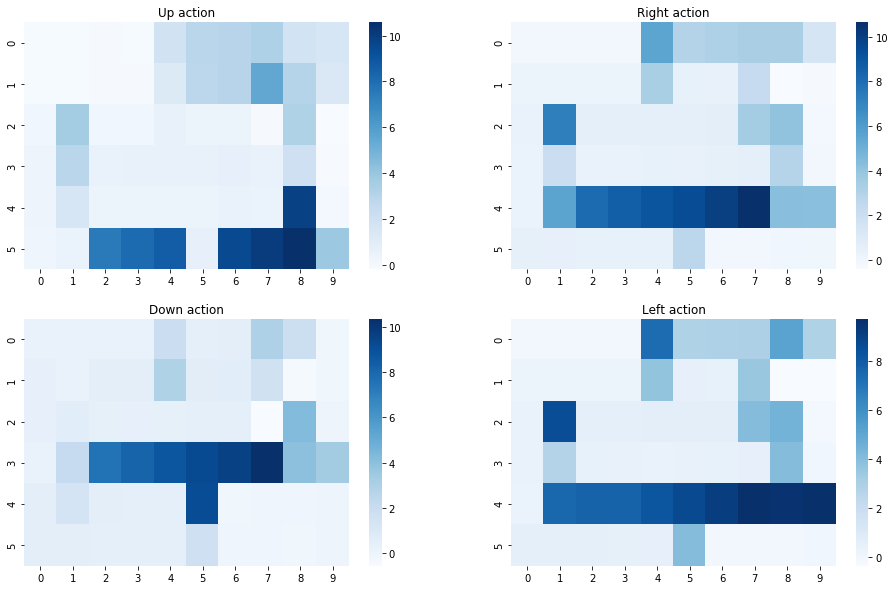

In [13]:
plot_q_values(q)
plt.savefig('results/evaluation/bernouilli/20200829-003541/q_eta_5e5.png', dpi = 300)

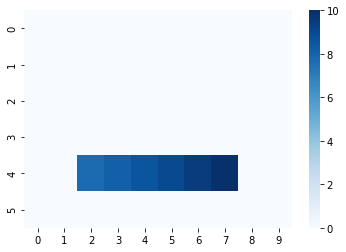

In [8]:
sns.heatmap(v_policy3.reshape(6,10), cmap = "Blues")

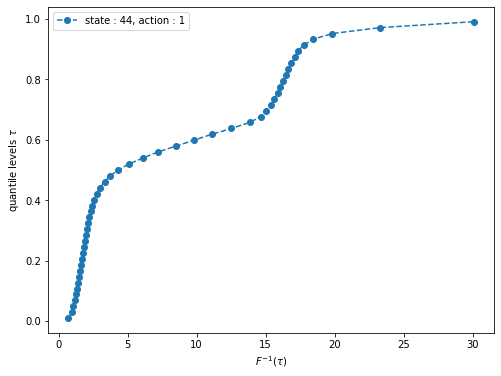

In [15]:
plot_theta(theta, 44, 1)

In [ ]:
filename = 'results/control/RMSVE'
run_experiment_2(filename, horde_info, env_info, 1, v_opt, horde_parameters, experiment_parameters)

  0%|          | 0/3 [00:00<?, ?it/s]

In [17]:
#rl = run_experiment(horde_info, env_info,num_episodes= 1000)

In [9]:
q = rl.horde.horde_message("get action values" , 1)

In [11]:
theta = rl.horde.horde_message("get theta values", 1)

In [16]:
save_theta('results/evaluation/gaussian/policy_3', GVD_1, theta)

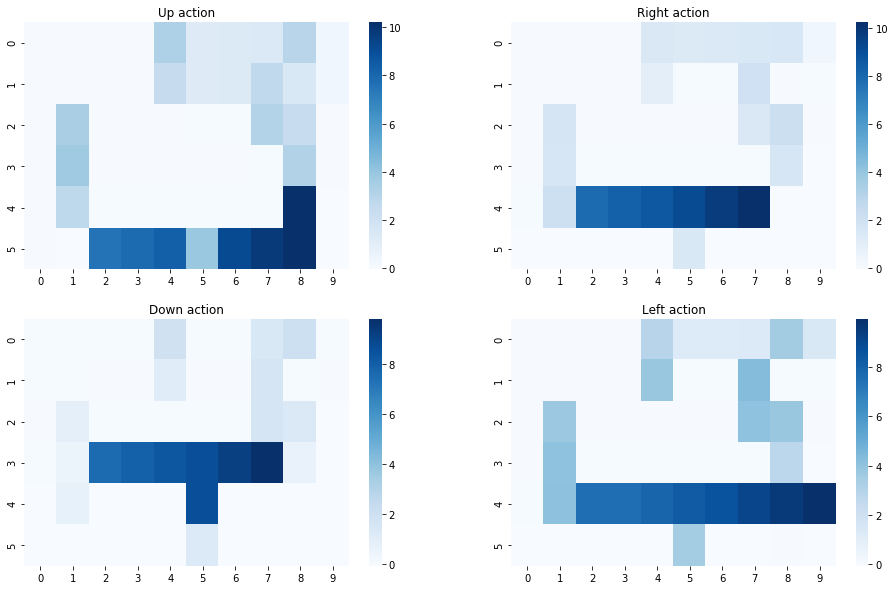

In [10]:
plot_q_values(q)